In [6]:
import torch
from PIL import Image
import os
import scipy.io
import numpy as np
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from livelossplot import PlotLosses
from src.data.transforms import get_transform
import pickle

## Data processing

In [7]:
def get_file_names(path, extension):
    """Returns a sorted list of file names that match the 
    specified file extension in the given directory.
    """
    file_names = []
    # Get file names of files with the correct extnesion
    for file in os.listdir(path):
        if file.endswith(extension):
            file_names.append(os.path.join(path, file))
    return sorted(file_names)

In [8]:
class ObjectDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, mask_paths, transforms):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        # Load mask
        mask_data = scipy.io.loadmat(mask_path)
        mask = mask_data["inst_map"]
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        labels = []
        masks_filtered = []
        # Skip images with no objects
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            if xmin == xmax or ymin == ymax:
                continue
            else:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(mask_data['class'])
                masks_filtered.append(masks[i])
                
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = np.array(labels)
        labels = torch.as_tensor(labels, dtype=torch.int64).view(-1)
        masks_filtered = np.array(masks_filtered).astype(int)
        masks_filtered = torch.as_tensor(masks_filtered, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        
        # target is a dictionary containing all the information we have just gathered
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks_filtered
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        return img, target
    
    def __len__(self):
        return len(self.img_paths)

In [9]:
def od_collate_fn(batch):
    ''' 
    Stack images and targets in batches of consistant size and shape for object detection.

    Args:
        batch: List of (image, target) tuples.

    Returns:
        Tuple of stacked images and targets.
    '''
    return tuple(zip(*batch))

In [10]:
def get_od_dataloader(img_paths, csv_paths, transform, batch_size, shuffle):
    '''Returns a dataloader for object detection.'''
    od_dataset = ObjectDetectionDataset(img_paths, csv_paths, transform)

    # Create PyTorch DataLoader for Object Detection
    od_dataloader = torch.utils.data.DataLoader(od_dataset,
                                                batch_size=batch_size,
                                                shuffle=shuffle,
                                                collate_fn=od_collate_fn)
    return od_dataloader

## Modelling

In [6]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT", 
                                                               weights_backbone="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [7]:
def get_sgd_optim(model, lr, momentum=0.9, weight_decay=0.0005):
    """Returns a stochastic gradient descent (SGD) optimizer associated with the input model, with entered hyperparameters.
    Used for training the detection and classification models.
    """
    # Filter model parameters that need to have gradients computed
    params = [param for param in model.parameters() if param.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum, weight_decay=weight_decay)
    return optimizer

In [8]:
def get_od_loss(model, loss_fn, dataloader, device):
    '''
    Returns loss for an object detection model on a given dataset.

    Args:
        model (Torch object): Torch object detection model
        loss_fn (function): Loss function TODO: customize and use loss_fn in the future
        dataloader: DataLoader
        device (str): Device to run training on ('cpu' or 'cuda')

    Returns:
        Loss for an object detection model on a given dataset.
    '''
    loss = 0
    with torch.no_grad():
        for batch_id, (images, targets) in enumerate(dataloader):
            # move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss += losses.item()
    loss = loss / len(dataloader)
    return loss

In [9]:
def train_detector(model, optimizer, loss_fn, n_epochs,
                   trainloader, valloader,
                   device,
                   save_path, name):
    '''
    Trains a detector model for object detection using the specified optimizer, loss function, and training/validation data loaders.

    Input:
        model (torch object): The detector model to train.
        optimizer (function): The optimizer to use for training.
        loss_fn (function): The loss function to use for training.
        n_epochs (int): The number of epochs to train for.
        trainloader (dataloader): The data loader for the training set.
        valloader (dataloader): The data loader for the validation set.
        device (str): The device to use for training and inference.
        save_path (str): The path to save the best model.
        name (str): The name of the model.

    Output:
        A tuple of four numpy arrays containing the training loss, validation loss, training statistics, and validation statistics.
    '''
    # create save path
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # initialize variables
    train_loss_list = []
    val_loss_list = []
    best_val_loss = float('inf')
    model = model.to(device)

    # plot live loss
    liveloss = PlotLosses()

    for epoch in range(n_epochs):
        logs = {}
        model.train()
        train_loss = 0
        for batch_id, (images, targets) in enumerate(trainloader):
            # move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # forward pass
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            train_loss += losses.item()

            # backward pass
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        # evaluate model
        train_loss /= len(trainloader)
        logs['loss'] = train_loss
        val_loss = get_od_loss(model, loss_fn, valloader, device)
        logs['val_loss'] = val_loss

        # record evaluation metrics
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        # save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model, save_path + name + '.pt')

        liveloss.update(logs)
        liveloss.send()

    return train_loss_list, val_loss_list

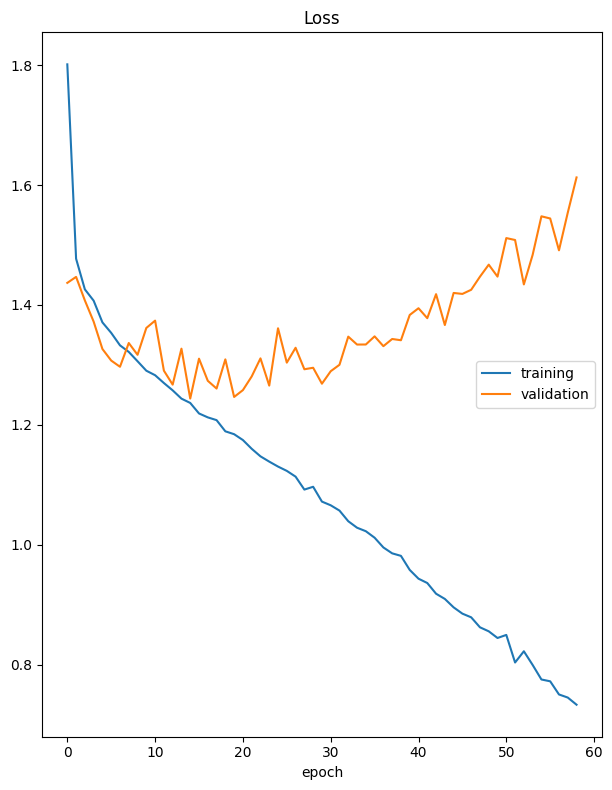

Loss
	training         	 (min:    0.733, max:    1.801, cur:    0.733)
	validation       	 (min:    1.244, max:    1.613, cur:    1.613)


In [10]:
def test_train():
    train_img_files = get_file_names("./data/benchmarks/NuCLS-split/train/rgb/", 'png')
    train_mask_files = get_file_names("./data/benchmarks/NuCLS-split/train/mask_mat/", 'mat')
    val_img_files = get_file_names("./data/benchmarks/NuCLS-split/val/rgb/", 'png')
    val_mask_files = get_file_names("./data/benchmarks/NuCLS-split/val/mask_mat/", 'mat')
    
    trainloader = get_od_dataloader(train_img_files, train_mask_files, get_transform(train=True), 8, True)
    valloader = get_od_dataloader(val_img_files, val_mask_files, get_transform(train=False), 8, False)
    
    model = get_model_instance_segmentation(15)
    optimizer = get_sgd_optim(model, 0.01)
    
    # Train the model
    device = torch.device("cuda:0")
    results = train_detector(
        model,
        optimizer,
        None,  # TODO: add customized loss function
        200,
        trainloader,
        valloader,
        device,
        './data/checkpoints/',
        'maskrcnn_nucls'
    )
    with open('./data/maskrcnn_nucls_results.pkl', 'wb') as file:
        pickle.dump(results, file)

# test_train()

## Inference

In [12]:
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F

In [13]:
def show(img, dpi):
    '''
    Shows an image.

    Args:
        img (tensor): The image tensor.
        dpi (int): The dots per inch.

    Returns:
        A matplotlib figure of the image.
    '''
    n_channels, height, width = img.shape

    # Create a figure with the appropriate dimensions and dots per inch
    fig, axs = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    
    # Convert the image tensor to PIL image and display it in the figure
    img = img.detach()
    img = F.to_pil_image(img)
    axs.imshow(np.asarray(img))
    axs.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    return fig

In [14]:
def visualize_predictions(file_paths, output, path, title, dpi, score_threshold=0.8):
    '''
    Visualize bounding box predictions for the test dataset.

    Args:
        file_paths (list): A list of file paths (string) to the images in the test dataset.
        output (dict): A dictionary containing the predictions made by the model.
        path (str): The directory where the output image should be saved.
        title (str): The title of the output image.
        dpi (int): The DPI of the output image.
        score_threshold (float): The minimum score threshold for drawing bounding boxes. 
            Defaults to 0.8.

    Returns:
        A figure object containing each image overlaid with predicted bounding boxes.
    '''
    img = read_image(file_paths)

    # Draw the predicted bounding boxes on the image
    result = draw_bounding_boxes(img, output['boxes'][output['scores'] > score_threshold],
                                 colors='blue', width=3)
    fig = show(result, dpi)
    if path:
        if not os.path.exists(path):
            os.makedirs(path)
        fig.savefig(path + title + '.png', bbox_inches='tight')
    return fig

In [15]:
def get_od_predictions(model, dataloader, device, idx):
    '''
    Returns object detection predictions for a given index in a dataloader.

    Args:
        model (Torch object): Object detection model
        dataloader: DataLoader
        device (str): Device to run training on ('cpu' or 'cuda')
        idx (int): Index of the image to predict on

    Returns:
        object detection results for a given index in a dataloader
    '''
    model.eval()
    with torch.no_grad():
        for batch_id, (images, targets) in enumerate(dataloader):
            if batch_id == idx:
                # move data to device
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # forward pass
                outputs = model(images)
                return outputs
    return None

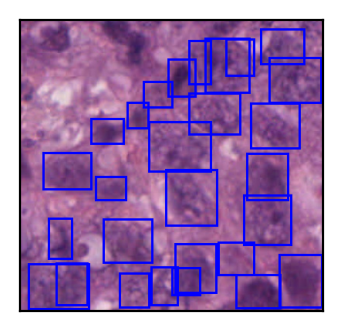

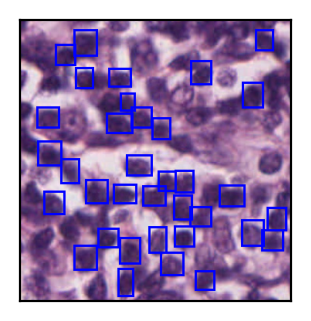

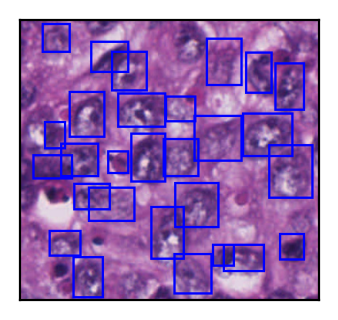

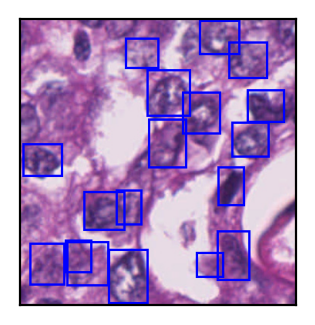

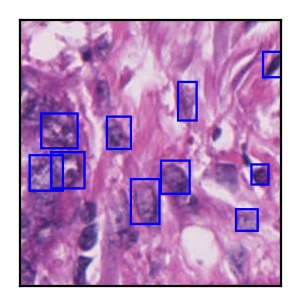

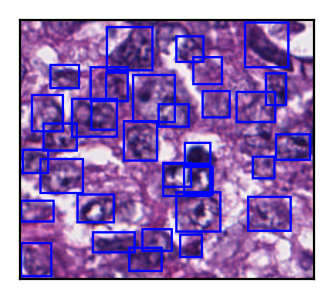

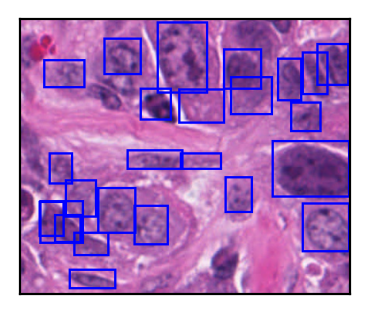

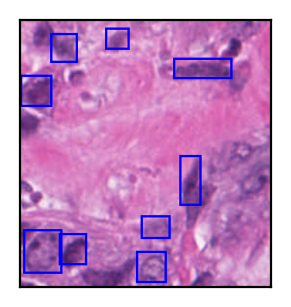

In [17]:
def test_infer():
    model = torch.load('./data/checkpoints/maskrcnn_nucls.pt')
    device = torch.device("cuda:0")
    batch = 0
    batch_size = 8
    val_img_files = get_file_names("./data/benchmarks/NuCLS-split/val/rgb/", 'png')
    val_mask_files = get_file_names("./data/benchmarks/NuCLS-split/val/mask_mat/", 'mat')
    valloader = get_od_dataloader(val_img_files, val_mask_files, get_transform(train=False), batch_size, False)
    preds = get_od_predictions(model, valloader, device, batch)
    for idx in range(len(preds)):
        visualize_predictions(val_img_files[idx + batch * batch_size],
                                preds[idx], './plot/', 'maskrcnn_nucls' + '_batch_' + str(batch) + '_idx_' + str(idx),
                                200, 0.5)

test_infer()